# **Mount**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Introduction**

* **Simple horizontal bar plot - Used to inspect the Target variable distribution**
* **Correlation Heatmap plot - Inspect the correlation between the diffrent features**
* **Scatter plot - Compare the feature importances generated by RandomForest and GradientBoosted model**
* **Vertical bar plot - List in Descending order, the importance of the various features**
* **3D Scatter plot**

**1. Data Quality Checks** - Visualising and evaluating all missing/Null values (values that are -1)

**2. Feature inspection and filtering** - Correlation and feature Mutual information plots against the target variable.  Inspection of the Binary, categorical and other variables.  

**3. Feature importance ranking via learning models** - Building a RandomForest and GradientBoosted model to help us rank features based off the learning process.

In [3]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('drive/MyDrive/input_2/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print(f'The train dataset contains {rows} rows and {columns} columns.')

The train dataset contains 595212 rows and 59 columns.


# **1. Data Quality checks**

#### **Null or missing values check**

In [6]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

* #### **Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as "Values of -1 indicate that the feature was missing from the observation'. Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.**

In [7]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

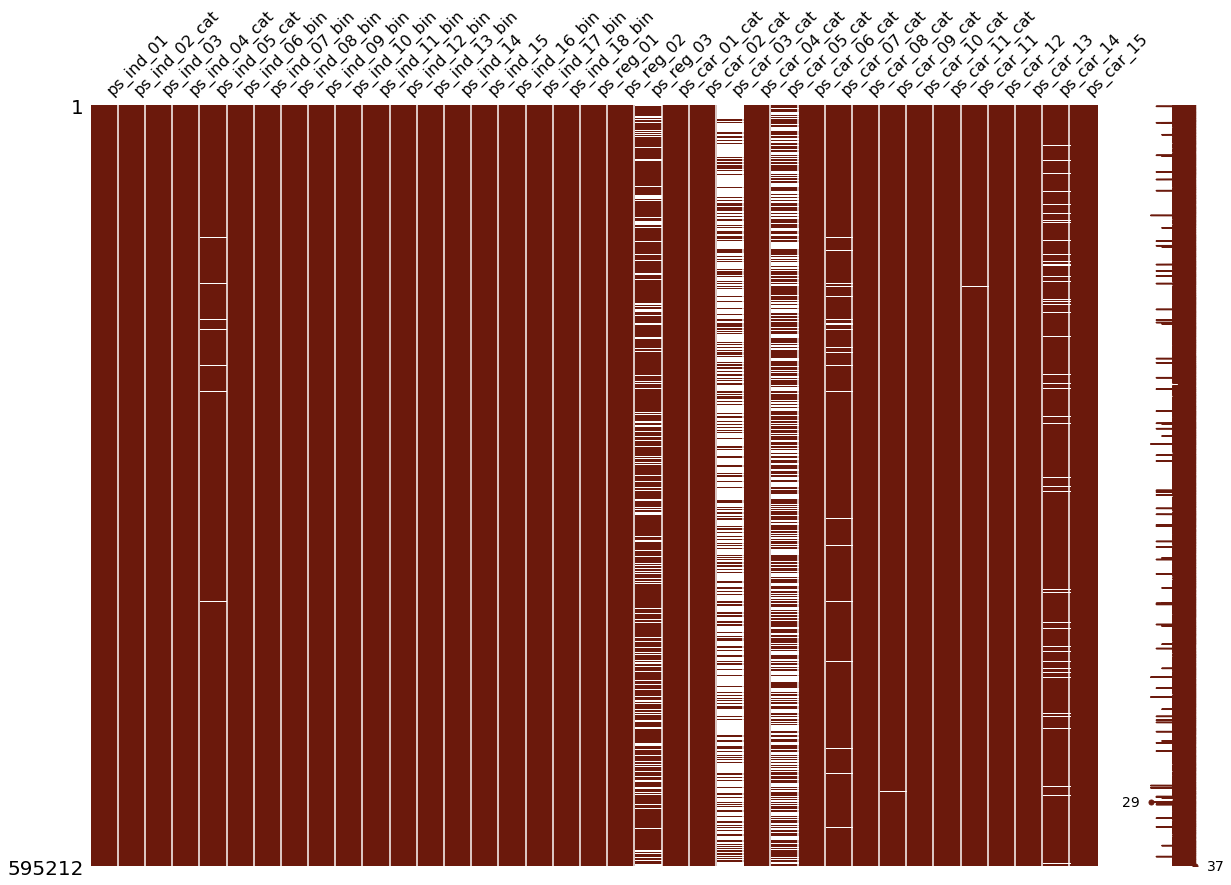

In [8]:
import missingno as msno

# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

#### **ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14**

**Most of the missing values occur in the columns suffixed with _cat. One should really take further note of the columns ps_reg_03, ps_car_03_cat and ps_car_05_cat. Evinced from the ratio of white to dark bands, it is very apparent that a big majority of values are missing from these 3 columns, and therefore a blanket replacement of -1 for the nulls might not be a very good strategy.**

#### **Target variable inspection**

**Another standard check normally conducted on the data is with regards to our target variable, where in this case, the column is conveniently titled 'target'. The target value also comes by the moniker of <U>_class / label / correct_</U> answer and is used in supervised learning models along with the corresponding data that is given (in our case all our train data except the id column) to learn the function that best maps the data to our target in the hope that this learned function can generalize and predict well with new unseen data.**

In [9]:
data = [go.Bar(
    x=train['target'].value_counts().index.values, 
    y=train['target'].value_counts().values, 
    text='Distribution of target variable'
)]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

#### **Datatype check**

In [10]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [14]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

# **Correlation plots**

#### **Correlation of float features**

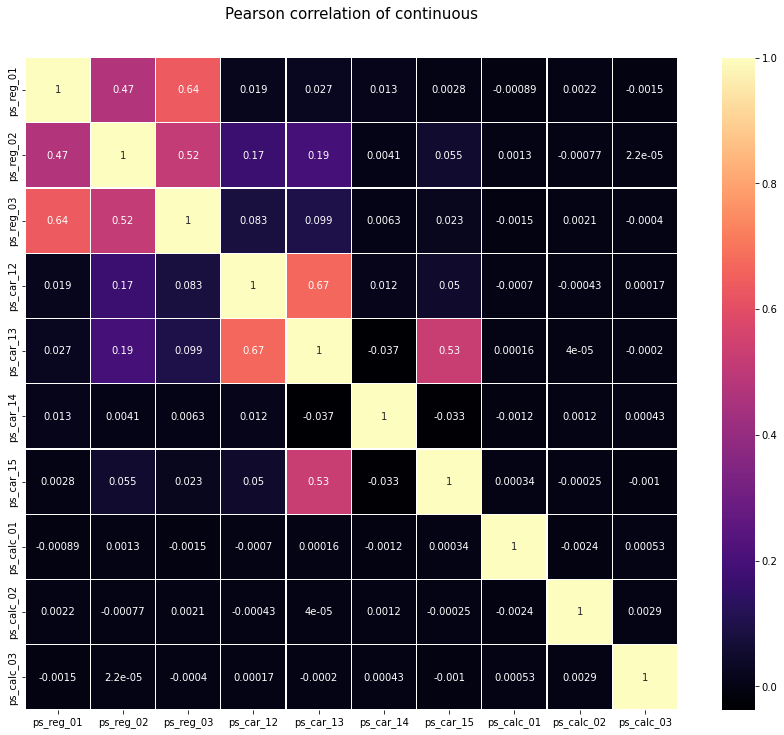

In [15]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title('Pearson correlation of continuous', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

* **(ps_reg_01, ps_reg_03)**
* **(ps_reg_02, ps_reg_03)**
* **(ps_car_12, ps_car_13)**
* **(ps_car_13, ps_car_15)**

#### **Corelation of interger features**

In [17]:
# train_int = train_int.drop(['id', 'target'], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21, 16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [
        go.Heatmap(
            z=train_int.corr().values, 
            x=train_int.columns.values, 
            y=train_int.columns.values, 
            colorscale='Viridis', 
            reversescale=False, 
            text=train_int.corr().values, 
            opacity=1.0
        )
]

layout = go.Layout(
    title='Pearson Correlation of Interger-type features', 
    xaxis=dict(ticks='', nticks=36), 
    yaxis=dict(ticks=''), 
    width=900, 
    height=700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

#### ***Negatively correlated features***: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

# **Mutual Information plots**

In [18]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


# **Binary features inspection**

In [19]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [20]:
trace1 = go.Bar(
    x=bin_col, 
    y=zero_list, 
    name='Zero count'
)

trace2 = go.Bar(
    x=bin_col, 
    y=one_list, 
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', 
    title='Count of 0 and 1 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# **Categorical and Ordinal feature inspection**

**Let us first take a look at the features that are termed categorical as per their suffix '_cat'.**

# **Feature importance via RandomForest**

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print('Training Done')

Training Done


### **Plotly Scatter Plot of feature importances**

In [24]:
# Scatter Plot
trace = go.Scatter(
    y=rf.feature_importances_, 
    x=features, 
    mode='markers', 
    marker=dict(
        sizemode='diameter', 
        sizeref=1, 
        size=13, 
        # size=rf.feature_importances_, 
        # color=np.random.randn(500), # set color equal to a variable, 
        color = rf.feature_importances_, 
        colorscale='Portland', 
        showscale=True
    ), 
    text=features
)

data = [trace]

layout = go.Layout(
    autosize=True, 
    title='RandomForest Feature Importance', 
    hovermode='closest', 
    xaxis=dict(
        ticklen=5, 
        showgrid=False, 
        zeroline=False, 
        showline=False
    ), 
    yaxis=dict(
        title='Feature Importance', 
        showgrid=False, 
        zeroline=False, 
        ticklen=5, 
        gridwidth=2
    ), 
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [26]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))
trace2 = go.Bar(
    x=x, 
    y=y, 
    marker=dict(
        color=x, 
        colorscale='Viridis', 
        reversescale=True
    ), 
    name='RandomForest Feature Importance', 
    orientation='h'
)

layout = dict(
    title='Barplot of Feature importances', 
    width=900, 
    height=2000, 
    yaxis=dict(
        showgrid=False, 
        showline=False, 
        showticklabels=True, 
        # domain=[0, 0.85]
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

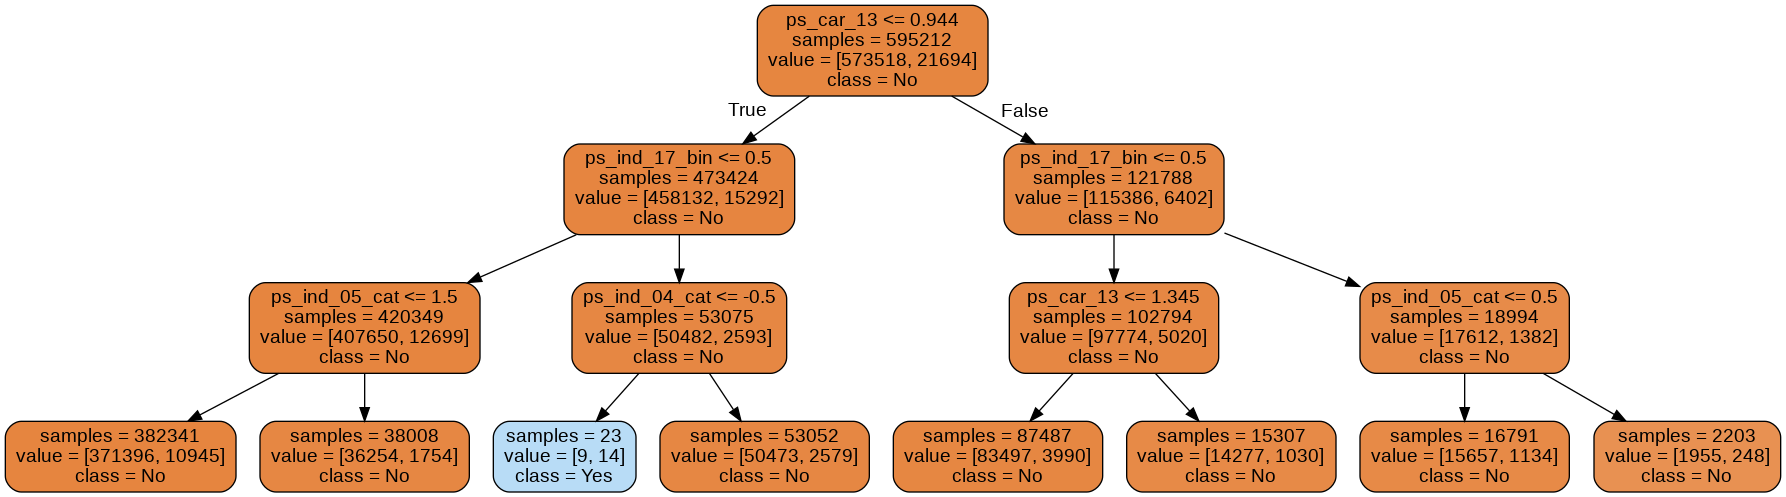

In [28]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

# Export our trained model as a '.dot' file
with open('tree1.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree, 
                             out_file=f, 
                             max_depth=4, 
                             impurity=False, 
                             feature_names=train.drop(['id', 'target'], axis=1).columns.values, 
                             class_names=['No', 'Yes'], 
                             rounded=True, 
                             filled=True
    )

# Convert '.dot' to '.png' to allow display in web notebook
check_call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png'])

# Annotating chart with PIL
img = Image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png')

# **Features importance via GradientBoosting model**

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print('Training Done')

Training Done


In [32]:
# Scatter Plot
trace = go.Scatter(
    y=gb.feature_importances_, 
    x=features, 
    mode='markers', 
    marker=dict(
        sizemode='diameter', 
        sizeref=1, 
        size=13, 
        # size=rf.feature_importances_, 
        # color = np.random.randn(500), # set color equal to a variable
        color=gb.feature_importances_, 
        colorscale='Portland', 
        showscale=True
    ), 
    text=features
)

data = [trace]

layout = go.Layout(
    autosize=True, 
    title='GradientBoosting Machine Feature Importance', 
    hovermode='closest', 
    xaxis=dict(
        ticklen=5, 
        showgrid=False, 
        zeroline=False, 
        showline=False
    ), 
    yaxis=dict(
        title='Feature Importance', 
        showgrid=False, 
        zeroline=False, 
        ticklen=5, 
        gridwidth=2
    ), 
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [36]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), reverse=False)))
trace2 = go.Bar(
    x=x, 
    y=y, 
    marker=dict(
        color=x, 
        colorscale='Viridis', 
        reversescale=True
    ), 
    name='GradientBoosting Classifier Feature Importance', 
    orientation='h'
)

layout = dict(
    title='Barplot of Feature Importances', 
    width=900, 
    height=2000, 
    yaxis=dict(
        showgrid=False, 
        showline=False, 
        showticklabels=True
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

# **Conclusion**

**We have performed quite an extensive inspection of the Porto Seguro dataset by inspecting for null values and data quality, investigated linear correlations between features, inspected some of the feature distributions as well as implemented a couple of learning models _(RandomForest and GradientBoostingClassifier)_ so as to identify features that the models deemed important.**